# Demand Forecasting for Retail Products

This project leverages time series analysis to forecast weekly product demand based on the "Historical Product Demand" dataset. It aims to illustrate a comprehensive forecasting workflow, encompassing data cleaning, visualization, model development, and performance evaluation.

## Data Loading

We begin by loading the dataset and previewing the first few rows to understand its structure.

In [80]:
import pandas as pd
data = pd.read_csv('Historical_Product_Demand.csv')
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [81]:
data.info()
# Checking missing values in each column
print("\nMissing values in each column:")
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB

Missing values in each column:
Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64


## Data Exploration and Cleaning

We check the dataset for missing values and incorrect data types. We then clean the data by:
- Removing rows with missing dates.
- Converting the `Date` column to datetime.
- Converting `Order_Demand` to numeric.

In [82]:
cleaned_data = data.dropna(subset=['Date']).copy()
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], errors='coerce')
cleaned_data['Order_Demand'] = pd.to_numeric(cleaned_data['Order_Demand'], errors='coerce')
cleaned_data = cleaned_data.dropna(subset=['Order_Demand'])
cleaned_data.reset_index(drop=True, inplace=True)
cleaned_data.info()
cleaned_data.isnull().sum()
cleaned_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031437 entries, 0 to 1031436
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1031437 non-null  object        
 1   Warehouse         1031437 non-null  object        
 2   Product_Category  1031437 non-null  object        
 3   Date              1031437 non-null  datetime64[ns]
 4   Order_Demand      1031437 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 39.3+ MB


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100.0
1,Product_0979,Whse_J,Category_028,2012-01-19,500.0
2,Product_0979,Whse_J,Category_028,2012-02-03,500.0
3,Product_0979,Whse_J,Category_028,2012-02-09,500.0
4,Product_0979,Whse_J,Category_028,2012-03-02,500.0


## Aggregate Demand by Date

We aggregate product demand by date to analyze overall daily demand patterns.

In [83]:
daily_demand = cleaned_data.groupby('Date')['Order_Demand'].sum().reset_index()
daily_demand.head()

,Date,Order_Demand
0,2011-01-08,2.0
1,2011-05-31,108.0
2,2011-06-24,92000.0
3,2011-09-02,1250.0
4,2011-09-27,28.0


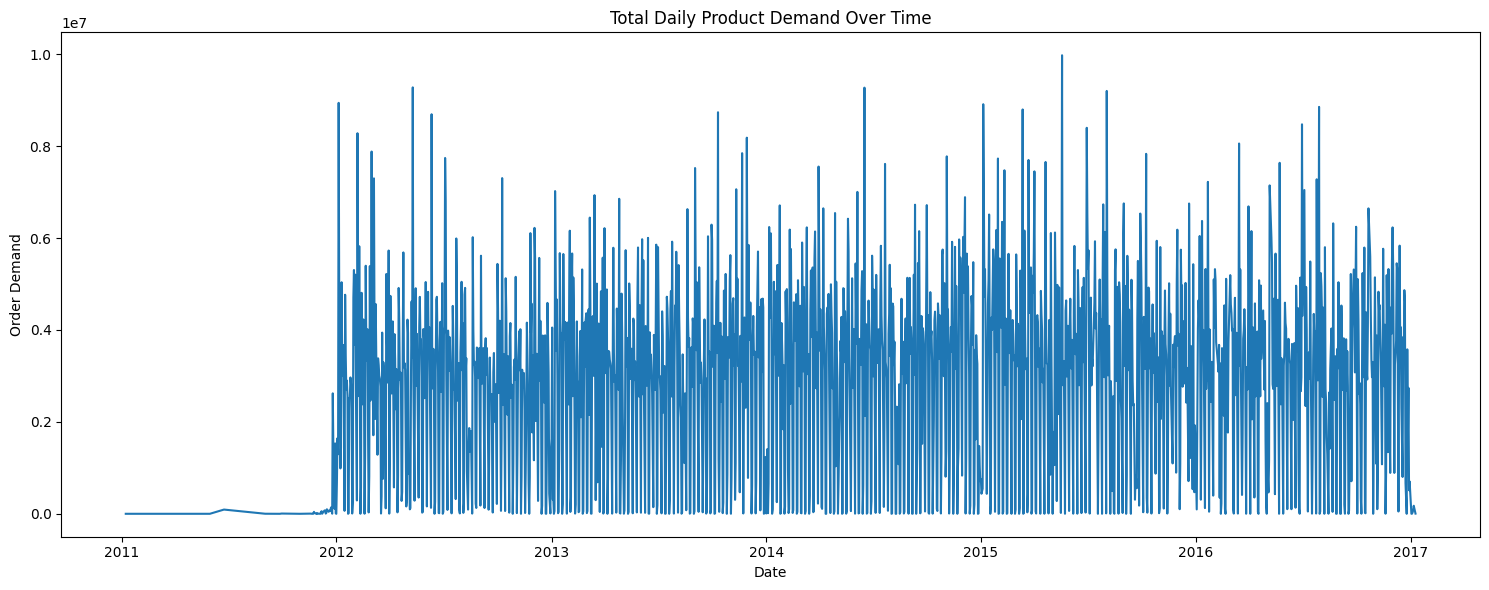

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(daily_demand['Date'], daily_demand['Order_Demand'])
plt.title('Total Daily Product Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.tight_layout()
plt.show()

## Resample to Weekly Demand

To smooth daily fluctuations, we resample the data to weekly totals.

In [85]:
weekly_demand = daily_demand.set_index('Date').resample('W').sum().reset_index()
weekly_demand.head()

,Date,Order_Demand
0,2011-01-09,2.0
1,2011-01-16,0.0
2,2011-01-23,0.0
3,2011-01-30,0.0
4,2011-02-06,0.0


## Visualize Weekly Demand

We plot the weekly product demand to observe trends and seasonality.

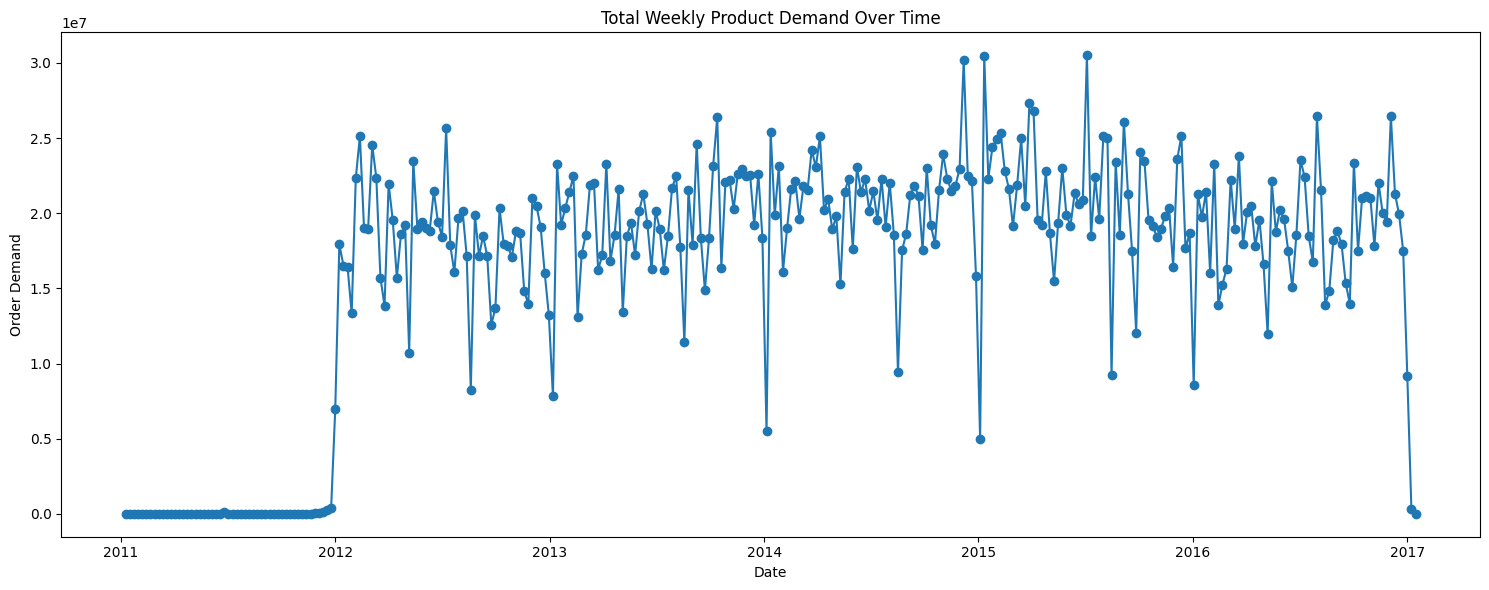

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(weekly_demand['Date'], weekly_demand['Order_Demand'], marker='o')
plt.title('Total Weekly Product Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.tight_layout()
plt.show()

## Prepare Data for Forecasting

We set the date as the index, check for missing weeks, and split the data into training and test sets (last 12 weeks for testing).

In [87]:
weekly_demand.set_index('Date', inplace=True)
    
missing_weeks = weekly_demand.index.to_series().diff().dt.days.fillna(7) != 7
print(f"Number of missing weeks: {missing_weeks.sum()}")

Number of missing weeks: 0


## Split Data into Training and Test Sets

We reserve the last 12 weeks for testing and use the rest for training the model.

In [88]:
test_weeks = 12

train = weekly_demand.iloc[:-test_weeks]
test = weekly_demand.iloc[-test_weeks:]

print(f"Training set: {train.shape[0]} weeks")
print(f"Test set: {test.shape[0]} weeks")

Training set: 303 weeks
Test set: 12 weeks


## Build and Fit ARIMA Model

We use the ARIMA model, a standard time series forecasting method, to fit the training data.

In [89]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
model = ARIMA(train['Order_Demand'], order=(5,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Order_Demand   No. Observations:                  303
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5014.214
Date:                Mon, 19 May 2025   AIC                          10040.428
Time:                        12:53:06   BIC                          10062.691
Sample:                    01-09-2011   HQIC                         10049.336
                         - 10-23-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7116      0.043    -16.513      0.000      -0.796      -0.627
ar.L2         -0.5720      0.057    -10.041      0.000      -0.684      -0.460
ar.L3         -0.4348      0.066     -6.636      0.000      -0.563      -0.306
ar.L4         -0.2446      0.061     -3.995      0.000      -0.365      -0.125
ar.L5         -0.0880      0.051     -1.740      0.082      -0.187       0.011
sigma2      1.569e+13   8.32e-16   1.89e+28      0.000    1.57e+13    1.57e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               136.60
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+42. Standard errors may be unstable.
"""

## Forecast and Evaluate

We forecast demand for the test period and compare the predicted values to the actual demand. The plot below shows training data, actual test demand, and the ARIMA forecast.

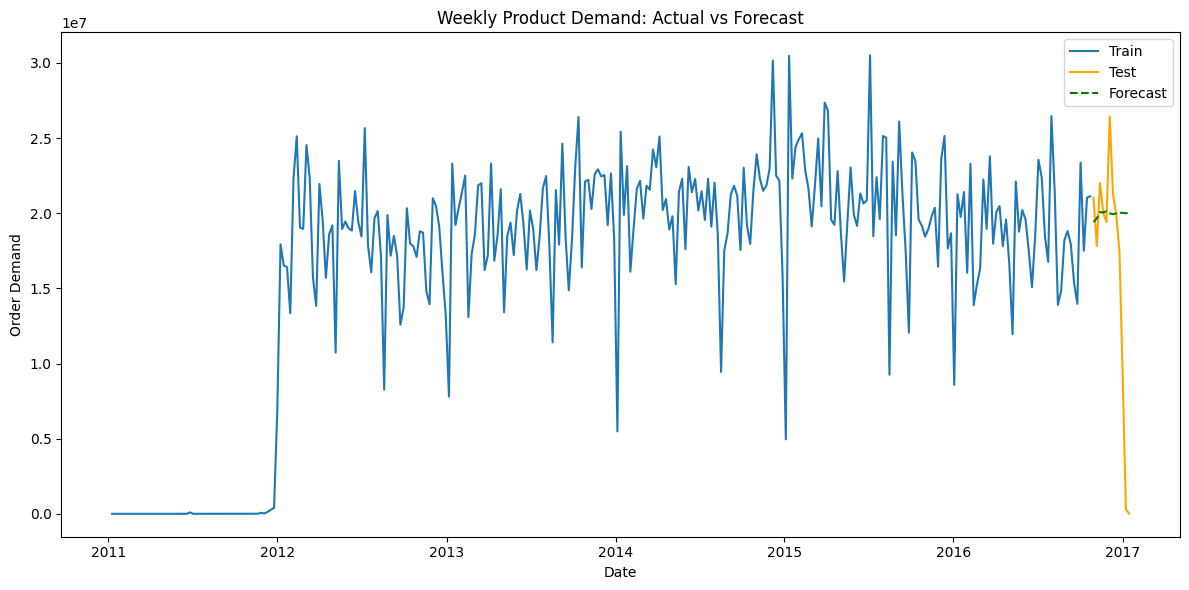

In [90]:
forecast = model_fit.forecast(steps=len(test))
results = test.copy()
results['Forecast'] = forecast.values
results[['Order_Demand', 'Forecast']]

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Order_Demand'], label='Train')
plt.plot(test.index, test['Order_Demand'], label='Test', color='orange')
plt.plot(results.index, results['Forecast'], label='Forecast', color='green', linestyle='--')
plt.title('Weekly Product Demand: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.legend()
plt.tight_layout()
plt.show()

## Results and Conclusion

- The ARIMA model serves as a solid baseline for forecasting weekly product demand.
- While the forecast effectively captures overall trends, it may fall short in accurately reflecting abrupt fluctuations or extreme values in actual demand.
- To enhance predictive accuracy, more sophisticated models or the incorporation of additional features—such as holidays, promotional events, or product-level granularity—can be considered.
